In [136]:
"""Import CSV Guppy data"""
import pandas as pd
import time
import numpy as np
#matplotlib ipympl
import matplotlib.pyplot as plt
#matplotlib inline
from scipy import interpolate

In [137]:
"""Format notebook to work with CSV Guppy data"""
df = pd.read_csv("L230110.CSV", nrows=1313) # only looking at rows for first run (up to row 1347). Also removed rows of zeros at end.
columns = [
        'Date', 'Time', 'Lat', 'Lon', 'Speed m/s', 'Distance km',
        'RPM 1', 'Motor Load 1 %%', 'Motor Torque 1 %%', 'Motor Temp 1 C',
        # 'RPM 2', 'Motor Load 2 %%', 'Motor Torque 2 %%', 'Motor Temp 2 C',
        # 'RPM 3', 'Motor Load 3 %%', 'Motor Torque 3 %%', 'Motor Temp 3 C',
        # 'RPM 4', 'Motor Load 4 %%', 'Motor Torque 4 %%', 'Motor Temp 4 C',
        # 'Depth m',
        # 'Temp Source 1', 'Temp 1 C',
        # 'Temp Source 2', 'Temp 2 C',
        # 'Temp Source 3', 'Temp 3 C',
        # 'Temp Source 4', 'Temp 4 C',
        'Pack Current 1 A', 'Pack Voltage 1 V', 'Pack Temp 1 C', 'SOC 1 %%',
        # 'Pack Current 2 A', 'Pack Voltage 2 V', 'Pack Temp 2 C', 'SOC 2 %%',
        # 'Pack Current 3 A', 'Pack Voltage 3 V', 'Pack Temp 3 C', 'SOC 3 %%',
        # 'Pack Current 4 A', 'Pack Voltage 4 V', 'Pack Temp 4 C', 'SOC 4 %%'
        ]

df = df[columns]


"""Adjust time format"""

df.Time = (pd.to_datetime(df['Time'].str.strip(), format = '%H:%M:%S'))
adjusted_time = np.array(0)
x = 0
for i in range(len(df.Time)):
    if i+1 >= len(df.Time):
        break
    x += (df.Time[i+1] - df.Time[i]).total_seconds()
    adjusted_time = np.append(adjusted_time,x)
df['Time'] = adjusted_time.astype(float)


"""Clean non-numeric data rows by trying to convert to a 
float value and dropping the row if it is unable to.
UNNECESSARY IF DATA IS ALREADY CLEAN."""

cnt=0
for row in df['Speed m/s']: # Arbitrary column that has numbers
    try:
        float(row)
        pass
    except ValueError:
        df.drop(cnt, inplace=True)
    cnt+=1

df.reset_index(inplace=True)
# df.info()

In [138]:
"""Initial Consumption Calculation"""
"""Calculate average kWh/nm for entire run"""

batt_cap = 22   # kWh
batt_health = 1.00 # %
batt_full = batt_cap*batt_health
nm_conversion = 0.539957

batt_consumed = (df['SOC 1 %%'].iloc[0] - df['SOC 1 %%'].iloc[-1])*batt_full/100   # kWh
dist_traveled = (df['Distance km'].iloc[-1] - df['Distance km'].iloc[0])*nm_conversion  # nm [1km = 0.539957nm]
time_spent = df['Time'].iloc[-1] - df['Time'].iloc[0]
avg_consumption_rate = batt_consumed/dist_traveled
print('Run Stats:', round(time_spent/60, 1), 'min |', round(dist_traveled, 2), 'nm traveled |', batt_consumed, 'kWh spent |', round(avg_consumption_rate, 1), 'kWh/nm')

Run Stats: 22.0 min | 1.8 nm traveled | 7.26 kWh spent | 4.0 kWh/nm


/tmp/ipykernel_403/4000326534.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  roll_consumption = roll_batt_consumed/roll_dist_traveled                                        #kWh/nm
/tmp/ipykernel_403/4000326534.py:16: RuntimeWarning: invalid value encountered in double_scalars
  roll_consumption = roll_batt_consumed/roll_dist_traveled                                        #kWh/nm


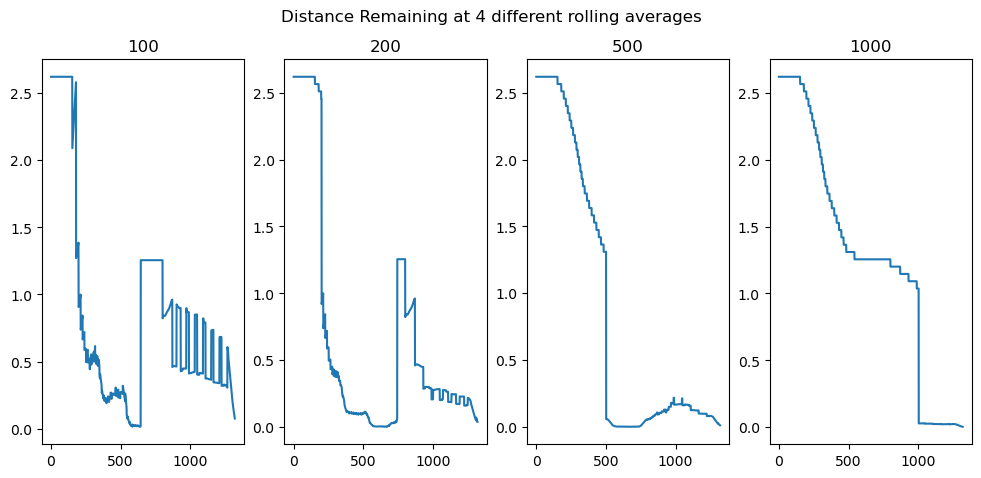

In [161]:
"""Test Loop:
Loop through CSV rows and update estimated mileage on each iteration.
This version is based on a rolling average consumption rate of N data points.
Any consumption rates that are not valid, or within the first N data points of the run,
will default to using the stored average consumption rate."""

Nlist = [50, 100, 200, 500, 1000]
distances = []
cached_avg = avg_consumption_rate    # This will need to be a locally stored value based on historical data. We want this to be conservative.
for N in Nlist:
    dist_list = []
    for i in range(len(df)):
        batt = df['SOC 1 %%'].iloc[i]*batt_full/100
        roll_batt_consumed = (df['SOC 1 %%'].iloc[i-N] - df['SOC 1 %%'].iloc[i])*batt_full/100      #kWh
        roll_dist_traveled = (df['Distance km'].iloc[i] - df['Distance km'].iloc[i-30])*nm_conversion   #nm
        roll_consumption = roll_batt_consumed/roll_dist_traveled                                        #kWh/nm

        if i < N or roll_consumption==0:
            dist_remaining = batt/cached_avg      # This will need to change because we won't know the average with real-time data
            print('%d Consumption Rate: %.2f kWh/nm | Dist Remaining %.1f nm' % (i, cached_avg, dist_remaining), end=' \r')
            # time.sleep(0.001)
        else:
            dist_remaining = batt/roll_consumption   #nm
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining: %.2f nm' % (i, batt, roll_consumption, dist_remaining), end=' \r')
            # time.sleep(.001)

        dist_list.append(dist_remaining)

    distances.append(dist_list)

plt.figure(figsize = (12,5))
plt.suptitle('Distance Remaining at 4 different rolling averages')

plt.subplot(1,4,1)
plt.title(Nlist[1])
plt.plot(df['Time'], distances[1])

plt.subplot(1,4,2)
plt.title(Nlist[2])
plt.plot(df['Time'], distances[2])

plt.subplot(1,4,3)
plt.title(Nlist[3])
plt.plot(df['Time'], distances[3])

plt.subplot(1,4,4)
plt.title(Nlist[4])
plt.plot(df['Time'], distances[4])


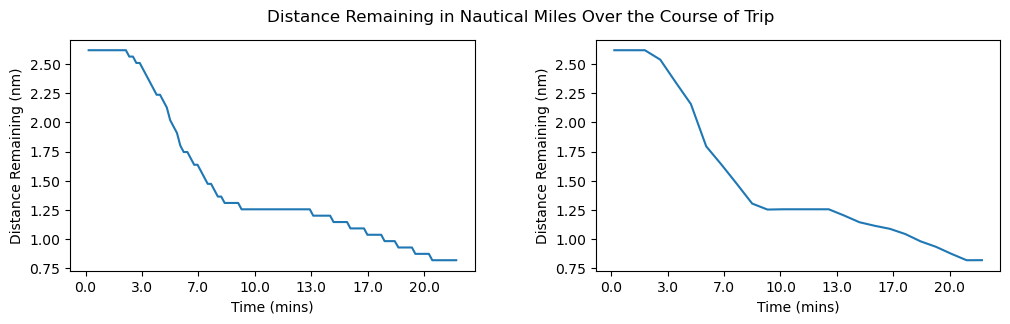

In [140]:
"""Test Loop for Plot: An attempt to plot time versus distance remaining, 
   calculated every 10 seconds in order to smooth final curve.
   Currently not yet working, running into error of 'Output exceeds the 
   size limit. Open the full output data in a text editor'. I am inclined 
   to believe that matplotlib has trouble processing datetime format of the 
   'Time' column. 
"""
distanceList = [] 
time1 = []
count = 0
for i in range(len(df)):
    batt = df['SOC 1 %%'].iloc[i]*batt_cap/100        # Change into kWh based on 63 kWh full charge
    dist = batt/avg_consumption_rate            # In km. Will eventually need to be nm
    print('Battery Remaining = %.1f kWh | Distance Remaining = %.1f nm' % (batt, dist), end=' \r')
    time.sleep(.001)
    count += 1
    if count % 12 == 0:
        time2 = df['Time'].iloc[i]    #fixed it here, "Only append the current time value"
        time1.append(time2)
        distanceList.append(dist)

plt.figure(figsize = (12,3))
plt.suptitle('Distance Remaining in Nautical Miles Over the Course of Trip') 
plt.subplot(1,2,1)
plt.plot(time1, distanceList)
space = np.array(range(0,int(np.max(time1)),200))
plt.xticks(space,labels = np.round(space/60,0))
plt.xlabel("Time (mins)")
plt.ylabel('Distance Remaining (nm)')

#Smooth line version of graph 
plt.subplot(1,2,2)
x_smooth = np.linspace(np.min(time1),np.max(time1),num = 25) #Num represents number of points, play around to affect smoothness
bspline = interpolate.make_interp_spline(time1, distanceList)
y_smooth = bspline(x_smooth)

plt.plot(x_smooth,y_smooth)
plt.xticks(space,labels = np.round(space/60,0))
plt.xlabel("Time (mins)")
plt.ylabel('Distance Remaining (nm)')
plt.subplots_adjust(wspace = 0.3)